In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# scikit-learn 관련
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [52]:
df_train = pd.read_csv('/content/drive/MyDrive/data/stroke/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/stroke/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/data/stroke/sample_submission.csv')

# 시각화

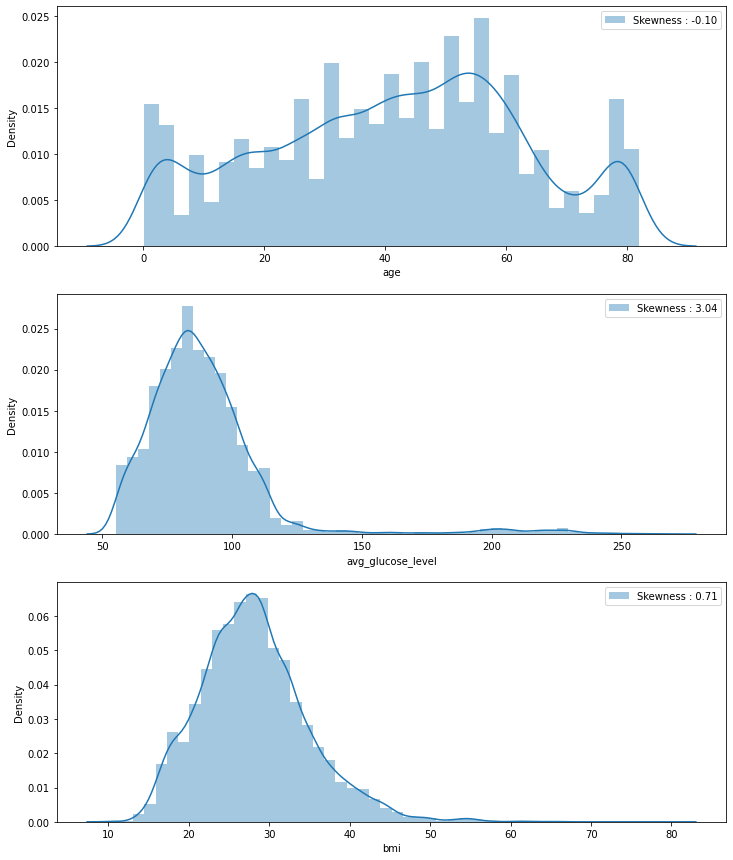

In [7]:
f, ax = plt.subplots(3, 1, figsize = (12,15))

sns.distplot(df_train['age'], label='Skewness : {:.2f}'.format(df_train['age'].skew()), ax = ax[0])
# sns.distplot(df_test['age'], ax = ax[0], label='Skewness : {:.2f}'.format(df_test['age'].skew()))
sns.distplot(df_train['avg_glucose_level'], label='Skewness : {:.2f}'.format(df_train['avg_glucose_level'].skew()), ax = ax[1])
# sns.distplot(df_test['avg_glucose_level'], ax = ax[1], label='Skewness : {:.2f}'.format(df_test['avg_glucose_level'].skew()))
sns.distplot(df_train['bmi'], label='Skewness : {:.2f}'.format(df_train['bmi'].skew()), ax = ax[2])
# sns.distplot(df_test['bmi'], ax = ax[2], label='Skewness : {:.2f}'.format(df_test['bmi'].skew()))
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
plt.show()

* avg_glucose_level 변수가 비대칭 분포를 보이고 있으므로 log를 취해 outlier의 영향을 줄여야 한다.

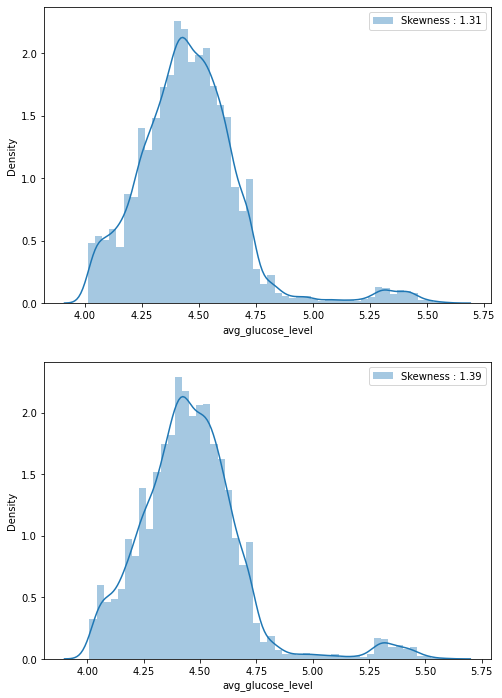

In [10]:
# log를 취한후 분포 시각화
fig, ax = plt.subplots(2, 1, figsize = (8, 12))

sns.distplot(df_train['avg_glucose_level'], label='Skewness : {:.2f}'.format(df_train['avg_glucose_level'].skew()), ax = ax[0])
ax[0].legend(loc='best')
sns.distplot(df_test['avg_glucose_level'], label='Skewness : {:.2f}'.format(df_test['avg_glucose_level'].skew()), ax = ax[1])
ax[1].legend(loc='best')

plt.show()

# 모델링

## 1

In [37]:
# 나이 변수 반올림
df_train['age'] = round(df_train['age'])
df_test['age'] = round(df_test['age'])

# avg_glucose_level 변수 log화
# df_train['avg_glucose_level'] = df_train['avg_glucose_level'].map(lambda i : np.log(i) if i > 0 else 0)
# df_test['avg_glucose_level'] = df_test['avg_glucose_level'].map(lambda i : np.log(i) if i > 0 else 0)

# 고혈압, 심장질환 변수 곱하기 -> 점수가 더 떨어짐
# df_train['hypertension * heart_disease'] = df_train['hypertension'] * df_train['heart_disease']
# df_test['hypertension * heart_disease'] = df_test['hypertension'] * df_test['heart_disease']

# 뇌졸중에 영향을 준다고 생각되는 변수 가져오기
df_Train = pd.get_dummies(data = df_train, columns = ['gender','ever_married','work_type','Residence_type','smoking_status'])
df_Test = pd.get_dummies(data = df_test, columns = ['gender','ever_married','work_type','Residence_type','smoking_status'])

# train 데이터 X, y 분리
X_train = df_Train.drop(['id','stroke'], axis = 1)
y_train = df_Train[['stroke']]
df_Test = df_Test.drop('id', axis = 1)

# 그리드서치를 하기 위한 여러 파라미터 설정
hyper_parameter = {
    'n_estimators' : [100, 200, 300],
    'max_depth' : [5, 10, 20]
}

# 그리드 서치로 최적의 파라미터 찾기
model = RandomForestClassifier()
hyper_parameter_tuner = GridSearchCV(model, hyper_parameter, cv = 5)
hyper_parameter_tuner.fit(X_train, y_train)

# 최적의 파라미터
hyper_parameter_tuner.best_params_

{'max_depth': 10, 'n_estimators': 300}

In [47]:
model = RandomForestClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy') # 그리드 서치로 찾은 파라미터보다 더 좋은 점수가 나옴
model.fit(X_train, y_train)
predictions = model.predict(df_Test)

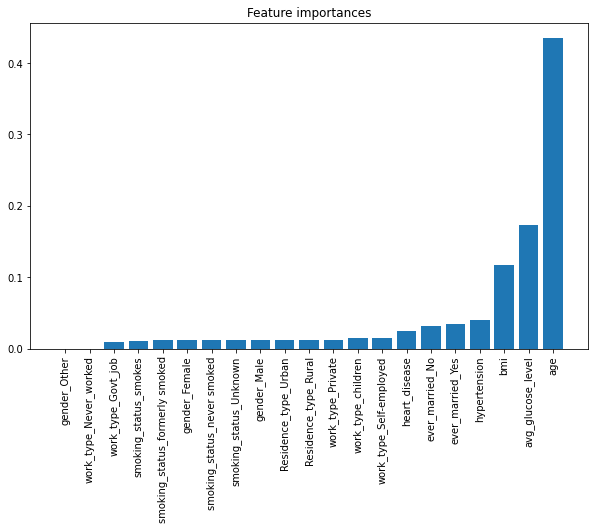

In [48]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = model.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

In [49]:
# 제출용 파일 만들기
sub = pd.read_csv('/content/drive/MyDrive/data/stroke/sample_submission.csv')

sub['stroke'] = predictions
sub.to_csv('/content/drive/MyDrive/data/stroke/sample_submission.csv', index = False)

In [50]:
sub[sub['stroke'] == 1]

,id,stroke
107,15411,1
2826,18130,1
2864,18168,1
3719,19023,1
3808,19112,1
7478,22782,1


In [19]:
sub[sub['stroke'] == 1]

,id,stroke
180,15484,1
698,16002,1
1176,16480,1
3405,18709,1
3466,18770,1
3719,19023,1
3808,19112,1
4014,19318,1
5923,21227,1
7037,22341,1


## 2

In [119]:
# 데이터가 문자형인 데이터 one-hot-encoding 처리
df_Train = pd.get_dummies(data = df_train, columns = ['gender','ever_married','work_type','Residence_type','smoking_status'])
df_Test = pd.get_dummies(data = df_test, columns = ['gender','ever_married','work_type','Residence_type','smoking_status'])

# train 데이터 X, y 분리
X_train = df_Train.drop(['id','stroke'], axis = 1)
y_train = df_Train['stroke']

# test 데이터 id 제외
df_Test = df_Test.drop('id', axis = 1)

In [123]:
model = RandomForestClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy',random_state = 42) # 그리드 서치로 찾은 파라미터보다 더 좋은 점수가 나옴
model.fit(X_train, y_train)
predictions = model.predict_proba(df_Test)[:,1]

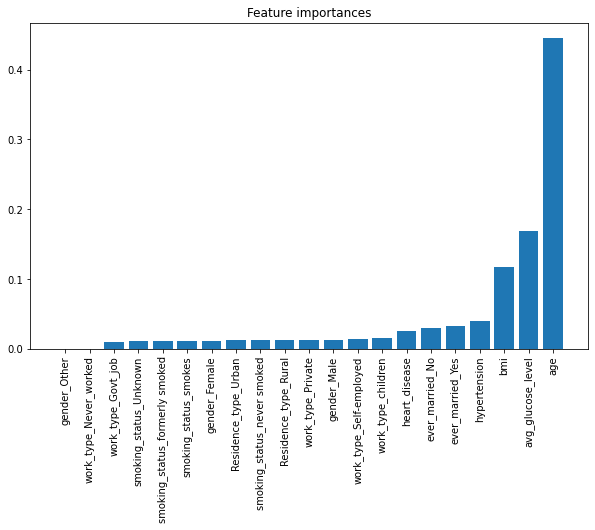

In [126]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = model.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

In [124]:
sub['stroke'] = predictions
sub.to_csv('/content/drive/MyDrive/data/stroke/sample_submission.csv', index = False)

In [125]:
sub['stroke'].sort_values()

3792    0.000000
1895    0.000000
8906    0.000000
857     0.000000
8696    0.000000
          ...   
2826    0.521038
7478    0.527856
3719    0.547350
107     0.581765
3808    0.627053
Name: stroke, Length: 10204, dtype: float64

In [122]:
sub['stroke'].sort_values()

6537    0.000000
7139    0.000000
5213    0.000000
6444    0.000000
7954    0.000000
          ...   
2826    0.562158
7478    0.564763
107     0.582208
3808    0.607572
3719    0.609900
Name: stroke, Length: 10204, dtype: float64